In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import statsmodels.api as sm
import numpy as np
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

### Read in the Data

In [2]:
data_f_path = '.\Data\\'
df_cancer = pd.read_csv(data_f_path + 'cancer_reg.csv',)

### Clean the Data

In [3]:
# drop variables with null values
cols_w_null_values = ['pctprivatecoveragealone','pctemployed16_over','pctsomecol18_24']  
df_cancer.drop(cols_w_null_values,axis=1,inplace=True)
# drop variables with object type
cols_w_type_obj = df_cancer.dtypes[df_cancer.dtypes == 'object'].index.to_list()
print('cols_w_type_obj:', cols_w_type_obj)
df_cancer.drop(cols_w_type_obj,axis=1,inplace=True)
# drop observations with median age above 100 years
#df_cancer.drop(df_cancer[(df_cancer['medianage'] > 100)].index,inplace = True)

cols_w_type_obj: ['binnedinc', 'geography']


### Transform the Data

In [4]:
# divide the data up into train and test sets
df_cancer_train, df_cancer_test = train_test_split(df_cancer, test_size = 0.2, random_state = 42)
# Separate the training data into two dfs, predictors (X) and response (y)
X_train = df_cancer_train.drop(columns=['target_deathrate'])
y_train = df_cancer_train['target_deathrate']
X_test = df_cancer_test.drop(columns=['target_deathrate'])
y_test = df_cancer_test['target_deathrate']

In [5]:
# https://stackoverflow.com/questions/40758562/can-anyone-explain-me-standardscaler
# Standardize the data sets
scaler = StandardScaler()
X_train_trans = scaler.fit_transform(X_train)
X_train_trans
print('size of X_train:',X_train.shape)
print('size of X_train_trans:',np.shape(X_train_trans))

size of X_train: (2437, 28)
size of X_train_trans: (2437, 28)


In [6]:
df_X_train_trans = pd.DataFrame(X_train_trans, columns = X_train.columns,index=y_train.index)

In [7]:
df_X_train_trans.insert(0,column='const',value=1)

In [8]:
X_train_trans

array([[-0.37602052, -0.31282017, -0.80227183, ..., -0.31662133,
        -0.05246479,  0.34838406],
       [-0.43887762, -0.37854788, -1.74470349, ..., -0.53035221,
         2.02699829, -0.24539736],
       [-0.26737861, -0.18355569, -0.33287537, ..., -0.43704778,
         1.69207091, -0.00450785],
       ...,
       [-0.0213823 ,  0.05744589,  0.16926969, ..., -0.38072939,
        -0.5488271 , -0.35135642],
       [ 1.05857076, -0.38731157,  0.10285231, ..., -0.52258444,
         1.70623144,  1.66623011],
       [ 0.11054001,  0.27215638,  0.55497531, ..., -0.44952052,
        -0.62624152, -0.40844767]])

In [9]:
df_X_train_trans.head()

,const,avganncount,avgdeathsperyear,incidencerate,medincome,popest2015,povertypercent,studypercap,medianage,medianagemale,medianagefemale,avghouseholdsize,percentmarried,pctnohs18_24,pcths18_24,pctbachdeg18_24,pcths25_over,pctbachdeg25_over,pctunemployed16_over,pctprivatecoverage,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds,birthrate
2830,1,-0.376021,-0.312820,-0.802272,0.023753,-0.271636,-0.478875,-0.291095,-0.103303,0.039439,0.100981,-0.354326,-0.105269,0.201673,-0.156766,-0.099638,0.057614,1.152448,-1.232370,1.023559,0.593498,-0.600401,-1.032989,0.528427,-0.481200,-0.245521,-0.316621,-0.052465,0.348384
1188,1,-0.438878,-0.378548,-1.744703,2.545803,-0.315782,-1.581173,-0.291095,-0.161168,-0.510313,-0.442143,0.601891,1.489953,1.464793,-1.527470,0.097419,0.043315,0.715121,-0.707916,1.108743,1.388256,-2.342928,-1.767273,0.735201,-0.627518,-0.278717,-0.530352,2.026998,-0.245397
887,1,-0.267379,-0.183556,-0.332875,2.835350,-0.181290,-1.470943,-0.291095,-0.045439,0.589190,0.363180,0.625213,0.808358,-0.570915,-0.046226,1.038914,-0.714556,1.589775,-0.737052,1.506268,1.526014,-0.964511,-0.949547,0.364684,-0.112104,-0.144619,-0.437048,1.692071,-0.004508
1924,1,-0.406285,-0.332538,-0.734955,-0.358368,-0.273177,-0.352898,-0.291095,-0.311187,-1.780428,-1.977875,1.698041,1.040391,1.562899,-0.598929,-1.041133,-1.257935,-0.710947,-1.086688,-0.471893,0.561708,-1.224590,-0.181887,-0.245534,-0.422345,2.801363,1.020523,1.793340,2.412272
2921,1,-0.379125,-0.284338,1.000720,-0.013074,-0.300514,-0.431634,-0.291095,-0.024007,0.721888,0.606649,-0.470938,1.098399,0.250726,-1.063200,-0.581333,0.029015,-0.863060,0.282719,0.105465,0.137836,0.804024,0.652528,0.886513,-0.599616,-0.336974,-0.559800,0.436037,-0.812808


### Run the Linear Regression Model

In [10]:
mod = sm.OLS(y_train, df_X_train_trans, hasconst= True)
res = mod.fit()
print(res.summary(alpha=.05))

                            OLS Regression Results                            
Dep. Variable:       target_deathrate   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     94.97
Date:                Mon, 12 Oct 2020   Prob (F-statistic):               0.00
Time:                        09:48:01   Log-Likelihood:                -10631.
No. Observations:                2437   AIC:                         2.132e+04
Df Residuals:                    2408   BIC:                         2.149e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    178

### Use Scikit Learn to Train Linear Regression Model

In [11]:
lin_reg = LinearRegression()
lin_reg.fit(df_X_train_trans,y_train)
y_train_predictions = lin_reg.predict(df_X_train_trans)
lin_mse = mean_squared_error(y_train,y_train_predictions)
print('Mean Squared Error:' , lin_mse)
lin_rmse = np.sqrt(lin_mse)
print('Root Mean Squared Error:', lin_rmse)
r2 = r2_score(y_train,y_train_predictions)
print('R^2:',r2)

Mean Squared Error: 360.1117488557265
Root Mean Squared Error: 18.97661057343293
R^2: 0.5247777445865737


In [12]:
res.mse_resid

364.4486428411152

### Perform Lasso Regularization

In [13]:
# https://towardsdatascience.com/how-to-perform-lasso-and-ridge-regression-in-python-3b3b75541ad8
lasso = Lasso()
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv = 5)
lasso_regressor.fit(df_X_train_trans,y_train)

C:\Users\barker.FRENCH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 151894.0964850714, tolerance: 147.36189307234483
  positive)
C:\Users\barker.FRENCH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84041.22101550084, tolerance: 147.0634658573627
  positive)
C:\Users\barker.FRENCH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 235728.25316436667, tolerance: 147.2217835261538
  positive)
C:\Users\barker.FRENCH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_coordin

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1,
                                   5, 10, 20]},
             scoring='neg_mean_squared_error')

In [ ]:
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)
lasso_regressor

In [15]:
lasso = Lasso(alpha=.01)
res = lasso.fit(df_X_train_trans,y_train)
res.coef_

array([ 0.        , -4.28094235,  8.79191341, 10.72594479,  1.49043671,
       -5.44903792,  3.55101142, -0.03116545, -0.25666408, -2.89579969,
        0.69786476, -0.25671318,  5.34096501, -1.04217796,  2.48760646,
       -0.18025953,  2.40819878, -7.70362977,  0.87621731, -6.14318106,
        2.74869692, -0.72404617,  0.38253684, -2.18018799, -1.62527329,
        0.28513144, -3.18540102, -5.76556447, -1.87201858])

#### Try out Best Lasso

In [16]:
X_test_trans = scaler.transform(X_test)
df_X_test_trans = pd.DataFrame(X_test_trans, columns = X_test.columns,index=y_test.index)
df_X_test_trans.insert(0,column='const',value=1)
final_lasso = lasso_regressor.best_estimator_
final_predictions = final_lasso.predict(df_X_test_trans)
final_mse = mean_squared_error(y_test,final_predictions)
final_rmse = np.sqrt(final_mse)
print('final_mse:', final_mse)
print('final_rmse:',final_rmse)

final_mse: 420.0490316245353
final_rmse: 20.495097746157136


In [17]:
final_predictions;

In [18]:
cvres = lasso_regressor.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print('negative mean square error:', mean_score)
    print('mean square error:', np.sqrt(-mean_score),params)

negative mean square error: -376.48071702798245
mean square error: 19.40311101416426 {'alpha': 1e-15}
negative mean square error: -376.4807170236751
mean square error: 19.403111014053263 {'alpha': 1e-10}
negative mean square error: -376.48071659722865
mean square error: 19.40311100306414 {'alpha': 1e-08}
negative mean square error: -376.4764147384332
mean square error: 19.403000147874895 {'alpha': 0.0001}
negative mean square error: -376.4380355698082
mean square error: 19.40201112178344 {'alpha': 0.001}
negative mean square error: -376.10661627101047
mean square error: 19.393468391987298 {'alpha': 0.01}
negative mean square error: -386.6366478799864
mean square error: 19.663078291050628 {'alpha': 1}
negative mean square error: -462.67622529380105
mean square error: 21.509909932256832 {'alpha': 5}
negative mean square error: -631.3855294104563
mean square error: 25.127386044124375 {'alpha': 10}
negative mean square error: -758.600104436765
mean square error: 27.54269602701894 {'alpha':

In [19]:
cvres.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_alpha', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

### Perform Ridge Regularization

In [20]:
# https://towardsdatascience.com/how-to-perform-lasso-and-ridge-regression-in-python-3b3b75541ad8
ridge = Ridge()
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv = 5)
ridge_regressor.fit(df_X_train_trans,y_train)

C:\Users\barker.FRENCH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.92201e-20): result may not be accurate.
  overwrite_a=True).T
C:\Users\barker.FRENCH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.05408e-20): result may not be accurate.
  overwrite_a=True).T
C:\Users\barker.FRENCH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.77768e-20): result may not be accurate.
  overwrite_a=True).T
C:\Users\barker.FRENCH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.81855e-20): result may not be accurate.
  overwrite_a=True).T
C:\Users\barker.FRENCH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWar

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1,
                                   5, 10, 20]},
             scoring='neg_mean_squared_error')

In [21]:
print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

{'alpha': 20}
-375.5966975489716


In [22]:
ridge = Ridge(alpha=20)
res = ridge.fit(df_X_train_trans,y_train)
res.coef_

array([ 0.        , -3.81995497,  6.89639348, 10.65119377,  1.21131845,
       -3.98708434,  3.26555349, -0.04963221, -0.27144107, -2.69402469,
        0.66054985, -0.30355723,  4.73052303, -1.00038192,  2.51432273,
       -0.1988134 ,  2.49650689, -7.4857626 ,  0.95158915, -5.61531866,
        2.50421691, -1.0547848 ,  0.99715669, -2.10677577, -1.5597305 ,
        0.25875154, -3.16518956, -5.35631837, -1.85576322])

### Drop Predictors that are Not Significant

In [23]:
cols_to_drop = ['medincome','studypercap','medianage','medianagemale',
                'medianagefemale','avghouseholdsize','pctnohs18_24',
                'pctbachdeg18_24','pctpubliccoverage','pctpubliccoveragealone',
               'pctblack','pctasian']

In [24]:
df_X_train_trans.drop(columns=cols_to_drop,axis=1,inplace=True)

In [25]:
X_train_trans = sm.add_constant(X_train_trans)
mod = sm.OLS(y_train, df_X_train_trans, hasconst= True)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       target_deathrate   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     162.3
Date:                Mon, 12 Oct 2020   Prob (F-statistic):               0.00
Time:                        09:48:04   Log-Likelihood:                -10649.
No. Observations:                2437   AIC:                         2.133e+04
Df Residuals:                    2420   BIC:                         2.143e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  178.6085 

### Post-Not Significant Variable Drop - Use Scikit Learn to Train Linear Regression Model

In [26]:
lin_reg = LinearRegression()
lin_reg.fit(df_X_train_trans,y_train)
y_train_predictions = lin_reg.predict(df_X_train_trans)
lin_mse = mean_squared_error(y_train,y_train_predictions)
lin_rmse = np.sqrt(lin_mse)
print('Root Mean Squared Error:', lin_rmse)
r2 = r2_score(y_train,y_train_predictions)
print('R^2:',r2)

Root Mean Squared Error: 19.119948257767685
R^2: 0.5175715561709802


In [27]:
# https://towardsdatascience.com/how-to-perform-lasso-and-ridge-regression-in-python-3b3b75541ad8
lasso = Lasso()
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv = 5)
lasso_regressor.fit(df_X_train_trans,y_train)
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

C:\Users\barker.FRENCH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 107354.08358160831, tolerance: 147.36189307234483
  positive)
C:\Users\barker.FRENCH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55533.262593659456, tolerance: 147.0634658573627
  positive)
C:\Users\barker.FRENCH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 260972.09062731994, tolerance: 147.2217835261538
  positive)
C:\Users\barker.FRENCH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_coord

{'alpha': 0.01}
-374.33733735030455


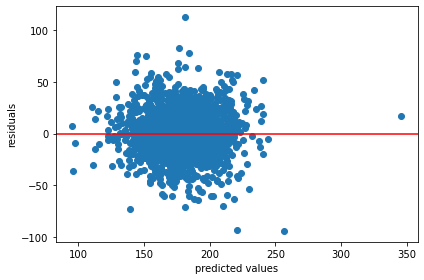

In [28]:
residuals = res.resid

y_pred = res.predict(df_X_train_trans)
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color = 'red', label = '0')

plt.xlabel('predicted values')

plt.ylabel('residuals')

plt.tight_layout()

### Remove Outliers

In [29]:
#https://medium.com/analytics-vidhya/ways-to-improve-a-linear-regression-model-e2c75fc0bdfd
f_75_percentile = y_train.describe()['75%']
f_25_percentile = y_train.describe()['25%']
#calculate the interquartile range
IQR = f_75_percentile - f_25_percentile
outlier_upper_bound = f_75_percentile + 1.5 * IQR
outlier_lower_bound = f_25_percentile - 1.5 * IQR
upper_outlier_indices = (y_train[y_train > outlier_upper_bound]).index
lower_outlier_indices = (y_train[y_train < outlier_lower_bound]).index
y_train.drop(index=upper_outlier_indices,inplace=True)
y_train.drop(index=lower_outlier_indices,inplace=True)
df_X_train_trans.drop(index=upper_outlier_indices,inplace=True)
df_X_train_trans.drop(index=lower_outlier_indices,inplace=True)

C:\Users\barker.FRENCH\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\series.py:4504: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [30]:
lin_reg = LinearRegression()
lin_reg.fit(df_X_train_trans,y_train)
y_train_predictions = lin_reg.predict(df_X_train_trans)
lin_mse = mean_squared_error(y_train,y_train_predictions)
lin_rmse = np.sqrt(lin_mse)
print('Root Mean Squared Error:', lin_rmse)
r2 = r2_score(y_train,y_train_predictions)
print('R^2:',r2)

Root Mean Squared Error: 17.904277869496692
R^2: 0.4725383968179476


In [31]:
# https://towardsdatascience.com/how-to-perform-lasso-and-ridge-regression-in-python-3b3b75541ad8
lasso = Lasso()
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv = 5)
lasso_regressor.fit(df_X_train_trans,y_train)
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

C:\Users\barker.FRENCH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63134.63987116539, tolerance: 114.15050805774278
  positive)
C:\Users\barker.FRENCH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 174669.194189757, tolerance: 116.33569204514437
  positive)
C:\Users\barker.FRENCH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 162251.72875878806, tolerance: 112.33052227701995
  positive)
C:\Users\barker.FRENCH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_coordi

{'alpha': 0.01}
-327.7071342271556


In [32]:
X_train_trans = sm.add_constant(X_train_trans)
mod = sm.OLS(y_train, df_X_train_trans, hasconst= True)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       target_deathrate   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     132.4
Date:                Mon, 12 Oct 2020   Prob (F-statistic):          1.08e-313
Time:                        09:48:07   Log-Likelihood:                -10252.
No. Observations:                2382   AIC:                         2.054e+04
Df Residuals:                    2365   BIC:                         2.064e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  178.2685 

### Check the Independence Assumption

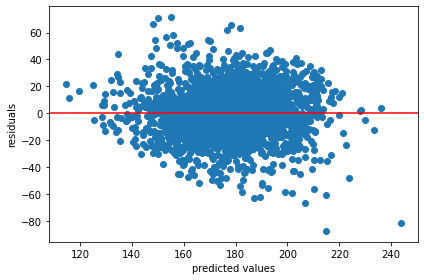

In [33]:
residuals = res.resid

y_pred = res.predict(df_X_train_trans)
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color = 'red', label = '0')

plt.xlabel('predicted values')

plt.ylabel('residuals')

plt.tight_layout()

# Start Again with 6 strongest variables

In [34]:
cols_to_read_in = ['incidencerate','medincome','povertypercent',
                   'percentmarried','pctprivatecoveragealone',
                   'pctpubliccoveragealone','target_deathrate']

In [35]:
data_f_path = '.\Data\\'
df_cancer = pd.read_csv(data_f_path + 'cancer_reg.csv',usecols=cols_to_read_in)

In [36]:
print(df_cancer.shape)

print(df_cancer.shape)

(3047, 7)
(3047, 7)


### Clean the Data

In [37]:
# drop rows with null values
df_cancer.dropna(inplace=True)

In [38]:
df_cancer.describe()

,target_deathrate,incidencerate,medincome,povertypercent,percentmarried,pctprivatecoveragealone,pctpubliccoveragealone
count,2438.000000,2438.000000,2438.000000,2438.000000,2438.000000,2438.000000,2438.000000
mean,178.851066,448.602300,47031.755127,16.908162,51.744668,48.453774,19.274897
std,27.815269,55.175406,12075.535857,6.422939,6.928303,10.083006,6.143687
min,59.700000,201.300000,22640.000000,3.200000,23.100000,15.700000,2.600000
25%,161.300000,421.400000,38647.000000,12.100000,47.700000,41.000000,14.800000
50%,178.550000,453.549422,45194.000000,15.900000,52.500000,48.700000,18.800000
75%,195.375000,480.500000,52404.250000,20.575000,56.300000,55.600000,23.200000
max,362.800000,1206.900000,125635.000000,47.400000,72.500000,78.900000,46.600000


### Remove Outliers

In [39]:
#https://medium.com/analytics-vidhya/ways-to-improve-a-linear-regression-model-e2c75fc0bdfd
f_75_percentile = y_train.describe()['75%']
f_25_percentile = y_train.describe()['25%']
#calculate the interquartile range
IQR = f_75_percentile - f_25_percentile
outlier_upper_bound = f_75_percentile + 1.5 * IQR
outlier_lower_bound = f_25_percentile - 1.5 * IQR
upper_outlier_indices = (y_train[y_train > outlier_upper_bound]).index
lower_outlier_indices = (y_train[y_train < outlier_lower_bound]).index
y_train.drop(index=upper_outlier_indices,inplace=True)
y_train.drop(index=lower_outlier_indices,inplace=True)
df_X_train_trans.drop(index=upper_outlier_indices,inplace=True)
df_X_train_trans.drop(index=lower_outlier_indices,inplace=True)

### Transform the Data

In [40]:
# divide the data up into train and test sets
df_cancer_train, df_cancer_test = train_test_split(df_cancer, test_size = 0.2, random_state = 42)
# Separate the training data into two dfs, predictors (X) and response (y)
X_train = df_cancer_train.drop(columns=['target_deathrate'])
y_train = df_cancer_train['target_deathrate']
X_test = df_cancer_test.drop(columns=['target_deathrate'])
y_test = df_cancer_test['target_deathrate']

In [41]:
# https://stackoverflow.com/questions/40758562/can-anyone-explain-me-standardscaler
# Standardize the data sets
scaler = MinMaxScaler()
X_train_trans = scaler.fit_transform(X_train)
X_train_trans
print('size of X_train:',X_train.shape)
print('size of X_train_trans:',np.shape(X_train_trans))

size of X_train: (1950, 6)
size of X_train_trans: (1950, 6)


In [42]:
df_X_train_trans = pd.DataFrame(X_train_trans, columns = X_train.columns,index=y_train.index)

In [43]:
df_X_train_trans.insert(0,column='const',value=1)

In [44]:
X_train_trans

array([[0.25735879, 0.0600694 , 0.71624714, 0.16801619, 0.25632911,
        0.72727273],
       [0.22384646, 0.17295827, 0.26315789, 0.74089069, 0.58860759,
        0.23636364],
       [0.28440732, 0.28699713, 0.26086957, 0.43522267, 0.65506329,
        0.29545455],
       ...,
       [0.21022275, 0.20601794, 0.18764302, 0.66194332, 0.26740506,
        0.39772727],
       [0.27058473, 0.19299807, 0.30892449, 0.56072874, 0.46835443,
        0.525     ],
       [0.20554893, 0.2499075 , 0.22196796, 0.63967611, 0.53322785,
        0.43863636]])

In [45]:
df_X_train_trans.head()

,const,incidencerate,medincome,povertypercent,percentmarried,pctprivatecoveragealone,pctpubliccoveragealone
2548,1,0.257359,0.060069,0.716247,0.168016,0.256329,0.727273
2818,1,0.223846,0.172958,0.263158,0.740891,0.588608,0.236364
818,1,0.284407,0.286997,0.260870,0.435223,0.655063,0.295455
513,1,0.196102,0.124089,0.487414,0.510121,0.382911,0.490909
214,1,0.242442,0.158598,0.398169,0.431174,0.430380,0.400000


### Run the Linear Regression Model

In [46]:
X_train_trans = sm.add_constant(X_train_trans)
mod = sm.OLS(y_train, df_X_train_trans, hasconst= True)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       target_deathrate   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     246.9
Date:                Mon, 12 Oct 2020   Prob (F-statistic):          6.79e-235
Time:                        09:48:07   Log-Likelihood:                -8712.6
No. Observations:                1950   AIC:                         1.744e+04
Df Residuals:                    1943   BIC:                         1.748e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

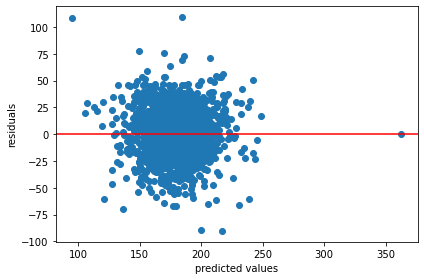

In [47]:
residuals = res.resid

y_pred = res.predict(X_train_trans)
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color = 'red', label = '0')

plt.xlabel('predicted values')

plt.ylabel('residuals')

plt.tight_layout()

https://www.cancer.org/content/dam/cancer-org/research/cancer-facts-and-statistics/annual-cancer-facts-and-figures/2020/cancer-facts-and-figures-2020.pdf